# Training

The `ConvNP` model can be trained using [the `Trainer` class](../reference/train/train.rst), which implements stochastic gradient descent using the Adam optimiser.


We will demonstrate training a `ConvNP` model with the following set-up:
- Goal: spatially interpolate daily-average ERA5 2m temperature over North America.
- Context data: ERA5 reanalysis data, 100km EarthEnv elevation data, and GLDAS land mask data.
- Training period: 2010-2018.
- Validation period: 2019.

In [1]:
import logging
logging.captureWarnings(True)

import deepsensor.torch
from deepsensor.model import ConvNP
from deepsensor.train import Trainer, set_gpu_default_device
from deepsensor.data import DataProcessor, TaskLoader, construct_circ_time_ds
from deepsensor.data.sources import get_era5_reanalysis_data, get_earthenv_auxiliary_data, get_gldas_land_mask

import xarray as xr
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from tqdm import tqdm_notebook

In [2]:
# Training/data config
data_range = ("2010-01-01", "2019-12-31")
train_range = ("2010-01-01", "2018-12-31")
val_range = ("2019-01-01", "2019-12-31")
date_subsample_factor = 2
extent = "north_america"
era5_var_IDs = ["2m_temperature"]
lowres_auxiliary_var_IDs = ["elevation"]
cache_dir = "../../.datacache"
deepsensor_folder = "../deepsensor_config/"
verbose_download = True

In [3]:
era5_raw_ds = get_era5_reanalysis_data(era5_var_IDs, extent, date_range=data_range, cache=True, cache_dir=cache_dir, verbose=verbose_download, num_processes=8)
lowres_aux_raw_ds = get_earthenv_auxiliary_data(lowres_auxiliary_var_IDs, extent, "100KM", cache=True, cache_dir=cache_dir, verbose=verbose_download)
land_mask_raw_ds = get_gldas_land_mask(extent, cache=True, cache_dir=cache_dir, verbose=verbose_download)

data_processor = DataProcessor(x1_name="lat", x2_name="lon")
era5_ds = data_processor(era5_raw_ds)
lowres_aux_ds, land_mask_ds = data_processor([lowres_aux_raw_ds, land_mask_raw_ds], method="min_max")

dates = pd.date_range(era5_ds.time.values.min(), era5_ds.time.values.max(), freq="D")
doy_ds = construct_circ_time_ds(dates, freq="D")
lowres_aux_ds["cos_D"] = doy_ds["cos_D"]
lowres_aux_ds["sin_D"] = doy_ds["sin_D"]

100%|██████████████████████████████████████████████████████████████████| 120/120 [24:32<00:00, 12.27s/it]


1.41 GB loaded in 1473.80 s


In [4]:
set_gpu_default_device()

## Initialise TaskLoader and ConvNP model

In [5]:
task_loader = TaskLoader(
    context=[era5_ds, land_mask_ds, lowres_aux_ds],
    target=era5_ds,
)
task_loader.load_dask()
print(task_loader)

TaskLoader(3 context sets, 1 target sets)
Context variable IDs: (('2m_temperature',), ('GLDAS_mask',), ('elevation', 'cos_D', 'sin_D'))
Target variable IDs: (('2m_temperature',),)


In [6]:
# Set up model
model = ConvNP(data_processor, task_loader, unet_channels=(32, 32, 32, 32, 32))

dim_yc inferred from TaskLoader: (1, 1, 3)
dim_yt inferred from TaskLoader: 1
dim_aux_t inferred from TaskLoader: 0
internal_density inferred from TaskLoader: 400
encoder_scales inferred from TaskLoader: [0.0012499999720603228, 0.0012499999720603228, 0.00416666641831398]
decoder_scale inferred from TaskLoader: 0.0025


## Define how Tasks are generated

We will generate `Task`s for a set of dates by randomly sampling between 0 and 500 ERA5 grid cells as context points,
and passing all ERA5 grid cells as target points.
All auxiliary data will be passed as context points.

In [7]:
def gen_tasks(dates, progress=True):
    tasks = []
    for date in tqdm_notebook(dates, disable=not progress):
        N_c = np.random.randint(0, 500)
        task = task_loader(date, context_sampling=[N_c, "all", "all"], target_sampling="all")
        tasks.append(task)
    return tasks

## Generate validation tasks for testing generalisation

In [8]:
val_dates = pd.date_range(val_range[0], val_range[1])[::date_subsample_factor]
val_tasks = gen_tasks(val_dates)

  0%|          | 0/183 [00:00<?, ?it/s]

## Print number of model parameters

Once the model has been compiled by running it with a `Task`, the number of `ConvNP` model parameters can be printed as below.
This is useful for checking that the model is not too large for the available GPU memory.

In [9]:
_ = model(val_tasks[0])
print(f"Model has {deepsensor.backend.nps.num_params(model.model):,} parameters")

Model has 339,590 parameters


## Training with the Trainer class

The `Trainer` class is initialised with a `ConvNP` model, and an optional learning rate.
Calling a `Trainer` object with a list of `Task`s will perform a single epoch of training, and return a list of losses for each task.
The `Trainer` class also implements a `train` method, which will train the model for a specified number of epochs, and return a list of losses for each epoch.

We will train the model for 50 epochs, and save the model with the best validation RMSE.


In [10]:
def compute_val_rmse(model, val_tasks):
    errors = []
    target_var_ID = task_loader.target_var_IDs[0][0]  # assume 1st target set and 1D
    for task in val_tasks:
        mean = data_processor.map_array(model.mean(task), target_var_ID, unnorm=True)
        true = data_processor.map_array(task["Y_t"][0], target_var_ID, unnorm=True)
        errors.extend(np.abs(mean - true))
    return np.sqrt(np.mean(np.concatenate(errors) ** 2))

In [11]:
losses = []
val_rmses = []

In [12]:
# Train model
val_rmse_best = np.inf
trainer = Trainer(model, lr=5e-5)
for epoch in tqdm_notebook(range(50)):
    train_tasks = gen_tasks(pd.date_range(train_range[0], train_range[1])[::date_subsample_factor], progress=False)
    batch_losses = trainer(train_tasks)
    losses.append(np.mean(batch_losses))
    val_rmses.append(compute_val_rmse(model, val_tasks))
    if val_rmses[-1] < val_rmse_best:
        val_rmse_best = val_rmses[-1]
        model.save(deepsensor_folder)

  0%|          | 0/50 [00:00<?, ?it/s]

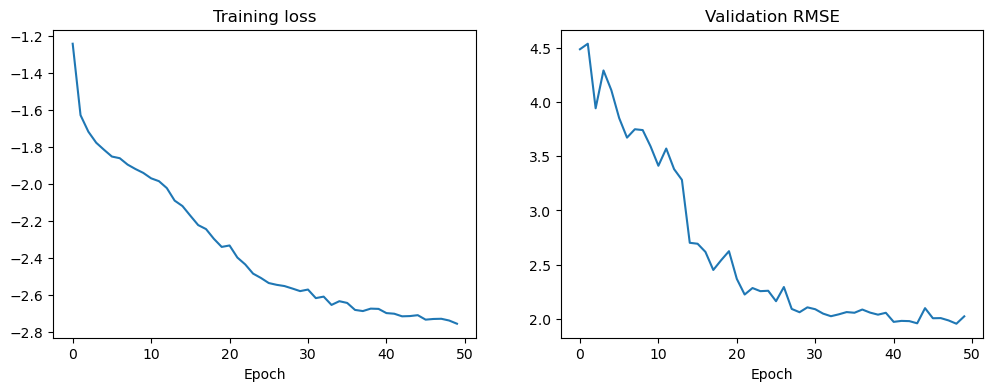

In [13]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
axes[0].plot(losses)
axes[1].plot(val_rmses)
_ = axes[0].set_xlabel("Epoch")
_ = axes[1].set_xlabel("Epoch")
_ = axes[0].set_title("Training loss")
_ = axes[1].set_title("Validation RMSE")

## Visualise trained model predictions 

We will use the high-level `model.predict` method to verify that the trained model is predicting sensible values.
See the [](./prediction.ipynb) page for more details on `model.predict`.

In [14]:
date = "2019-06-25"
test_task = task_loader(date, [200, "all", "all"], seed_override=42)
pred = model.predict(test_task, X_t=era5_raw_ds, resolution_factor=2)

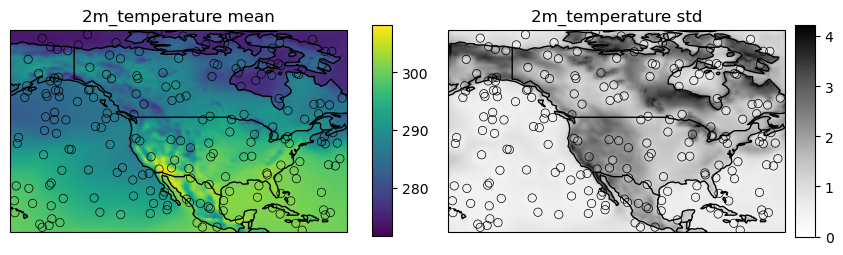

In [15]:
fig = deepsensor.plot.prediction(pred, date, data_processor, task_loader, test_task, crs=ccrs.PlateCarree())

Looks good!